In [694]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

1. Cargar los datos

In [695]:
calificaciones = pd.read_csv("./Datos/calificaciones.csv")
estudiantes = pd.read_csv("./Datos/estudiantes.csv")
carreras = pd.read_csv("./Datos/carrera.csv")
escuelas = pd.read_csv("./Datos/escuelas.csv")

## 1. Limpieza de datos
Primero eliminamos a aquellos estudiantes que su "prepa" no esta registrada como escuela.

In [696]:
estudiantes_filtrados = pd.merge(estudiantes, escuelas[['clave']], left_on='prepa', right_on='clave', how='inner')
estudiantes_filtrados

,clave_alumno,clave_carrera,sexo,prepa,colonia,municipio,ciudad,ingreso,termino,causa_salida,clave
0,248,4,1,125,FRAC.RINCON HYA,25006.0,"CULIACAN, SIN.",2003.0,2061.0,5,125
1,260,4,1,71,El Walamo,25006.0,"CULIACAN, SIN.",2003.0,2061.0,5,71
2,261,4,1,107,4 de Marzo,25006.0,"CULIACAN, SIN.",2003.0,2051.0,4,107
3,263,4,1,4,Libertad,25015.0,"CULIACAN, SIN.",2003.0,2051.0,5,4
4,264,4,1,79,El Chorizo,25006.0,"CULIACAN, SIN.",2003.0,2013.0,4,79
...,...,...,...,...,...,...,...,...,...,...,...
9840,11739,8,1,91,LA,25006.0,CULIACAN,2103.0,NaN,1,91
9841,11740,8,1,71,BALCONES,25006.0,CULIACAN,2103.0,NaN,1,71
9842,11825,8,1,26,San Miguel,25006.0,CULIACAN,2103.0,NaN,1,26
9843,11831,8,1,70,ADOLFO,25006.0,CULIACAN,2103.0,NaN,1,70


Ahora en nuestro dataframe principal (mainData) se filtraran a aquellos estudiantes que necesitamos solamente, aquellos que siguen vigentes y que no han terminado sus estudios.

In [697]:
mainData = estudiantes_filtrados[(estudiantes_filtrados['termino'].isnull()) & (estudiantes_filtrados['causa_salida']==1)]
mainData

,clave_alumno,clave_carrera,sexo,prepa,colonia,municipio,ciudad,ingreso,termino,causa_salida,clave
475,3327,4,1,121,BUENOS,25006.0,CULIACAN,2043.0,NaN,1,121
511,4420,4,1,154,El Walamo,25011.0,GUASAVE,2053.0,NaN,1,154
525,4434,4,1,127,Alcanfores,25018.0,NAVOLATO,2053.0,NaN,1,127
530,4440,4,1,117,Los Angeles,25006.0,CULIACAN,2053.0,NaN,1,117
532,4443,4,1,142,NaN,25002.0,LA REFORMA ANG.,2053.0,NaN,1,142
...,...,...,...,...,...,...,...,...,...,...,...
9839,11738,8,2,98,Fovissste Playa Azul,25006.0,CULIACAN,2103.0,NaN,1,98
9840,11739,8,1,91,LA,25006.0,CULIACAN,2103.0,NaN,1,91
9841,11740,8,1,71,BALCONES,25006.0,CULIACAN,2103.0,NaN,1,71
9842,11825,8,1,26,San Miguel,25006.0,CULIACAN,2103.0,NaN,1,26


Además ponemos la clave de los municipios correctos, si encuentra otra clave pone por default la de culiacan

In [698]:
#los municipios con clave le asignamos su ciudad correspondiente
mainData['ciudad'] = mainData['municipio'].apply(lambda x: 'Los Mochis' if x == 25001 else 'Angostura' if x == 25002 else 'Badiraguato' if x == 25003 else 'Concordia' if x == 25004 else 'Cosala' if x == 25005 else 'Culiacan' if x == 25006 else 'Choix' if x == 25007 else 'La Cruz' if x == 25008 else 'Escuinapa' if x == 25009 else 'El Fuerte' if x == 25010 else 'Guasave' if x == 25011 else 'Mazatlan' if x == 25012 else 'Mocorito' if x == 25013 else 'Rosario' if x == 25014 else 'Guamuchil' if x == 25015 else 'San Ignacio' if x == 25016 else 'Sinaloa de Leyva' if x == 25017 else 'Navolato' if x == 25018 else 'ElDorado' if x == 25019 else 'Juan Jose Rios' if x == 25020 else 'No encontrado')
#para los municipios que no tienen bien su clave se le asignan por default a culiacan
clave_municipios = [25001, 25002, 25003, 25004, 25005, 25006, 25007, 25008, 25009, 25010, 25011, 25012, 25013, 25014, 25015, 25016, 25017, 25018, 25019, 25020]
clave_cul = 25006
#si no esta en la lista de claves de municipios se le asigna a culiacan
mainData.loc[~mainData['municipio'].isin(clave_municipios), 'ciudad'] = 'Culiacan'
#ahora cambiamos los municipios que estan mal a la clave de culiacan
mainData['municipio'] = mainData['municipio'].apply(lambda x: clave_cul if x not in clave_municipios else x)


C:\Users\mari_\AppData\Local\Temp\ipykernel_17344\751862216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainData['ciudad'] = mainData['municipio'].apply(lambda x: 'Los Mochis' if x == 25001 else 'Angostura' if x == 25002 else 'Badiraguato' if x == 25003 else 'Concordia' if x == 25004 else 'Cosala' if x == 25005 else 'Culiacan' if x == 25006 else 'Choix' if x == 25007 else 'La Cruz' if x == 25008 else 'Escuinapa' if x == 25009 else 'El Fuerte' if x == 25010 else 'Guasave' if x == 25011 else 'Mazatlan' if x == 25012 else 'Mocorito' if x == 25013 else 'Rosario' if x == 25014 else 'Guamuchil' if x == 25015 else 'San Ignacio' if x == 25016 else 'Sinaloa de Leyva' if x == 25017 else 'Navolato' if x == 25018 else 'ElDorado' if x == 25019 else 'J

Ahora llegamos a la limpieza de las colonias en mainData, usando la funcion replace y con el apoyo visual en excel, buscamos aquellos que estan incorrectas y la reemplazamos por el correcto. Además normalizamos aquellos que tengan acentos.

In [699]:
mainData['colonia'] = mainData['colonia'].replace({
    '21': '21 DE MARZO', 
    '21DE': '21 DE MARZO',
    'ADF': 'ADOLFO LOPEZ MATEOS',
    'ADOLFO': 'ADOLFO LOPEZ MATEOS',
    'Adolfo': 'ADOLFO LOPEZ MATEOS',
    'Adolfo Lopez Mateos': 'ADOLFO LOPEZ MATEOS',
    'adolfo': 'ADOLFO LOPEZ MATEOS',
    'AF': 'ADOLFO LOPEZ MATEOS',
    'AGRI.': 'COLONIA AGRICOLA MEXICO',
    'AGRICOLA': 'COLONIA AGRICOLA MEXICO',
    'COL.AGRICOLA': 'COLONIA AGRICOLA MEXICO',
    'COLONIA AGRICOLA M√âXICO': 'COLONIA AGRICOLA MEXICO',
    'COLONIA AGRICOLA M√âXICO': 'COLONIA AGRICOLA MEXICO',
    'col.agricola': 'COLONIA AGRICOLA MEXICO',
    'Colonia Agricola Mexico': 'COLONIA AGRICOLA MEXICO',
    'COL.agricola': 'COLONIA AGRICOLA MEXICO',
    'AGUA': 'AGUACALIENTE',
    'AGUA CALIENTE': 'AGUACALIENTE',
    'ALFONSO': 'ALFONSO G. CALDERON',
    'Alfonso G Calderon': 'ALFONSO G. CALDERON',
    'AMP.TOLEDO': 'AMP. TOLEDO',
    'ALTURAS': 'ALTURAS DEL SUR',
    'AMADO': 'AMADO NERVO',
    'AQUILES': 'AQUILES SERDAN',
    'BALCONES': 'BALCONES DE NUEVO CULIACAN',
    'balcones': 'BALCONES DE NUEVO CULIACAN',
    'Balcones de Nuevo Culiac√°n': 'BALCONES DE NUEVO CULIACAN',
    'BUENOS': 'BUENOS AIRES',
    'Buenos Aires': 'BUENOS AIRES',
    'buenos': 'BUENOS AIRES',
    'BUENA': 'BUENA VISTA',
    'CNOP': 'AMP. CNOP',
    'AMPL.CNOP': 'AMP. CNOP',
    'CU': 'CD. UNIVERSITARIA',
    'C.U': 'CD. UNIVERSITARIA',
    'CIUDADES': 'CIUDADES HERMANAS',
    'CD.': 'CIUDADES HERMANAS',
    'CD. HERMANAS': 'CIUDADES HERMANAS',
    'cd.hermanas': 'CIUDADES HERMANAS',
    'CHULA': 'CHULAVISTA',
    'CHULA VISTA': 'CHULAVISTA',
    'Chula Vista': 'CHULAVISTA',
    'CONOCIDO': 'CONOCIDA',
    'CONOSIDO': 'CONOCIDA',
    'CONOSIDA': 'CONOCIDA',
    'FRAC.NAKAYAMA': 'FRACC. NAKAYAMA',
    'Frac.NAKAYAMA': 'FRACC. NAKAYAMA',
    'fracc.nakayama': 'FRACC. NAKAYAMA',
    'NAKAYAMA': 'FRACC. NAKAYAMA',
    'fracc.zona': 'FRACC. ZONA DORADA',
    'FRAC.': 'FRACC.',
    'FRA': 'FRACC.',
    'FRACC.-': 'FRACC.',
    'EJ.': 'EJIDAL',
    'E.': 'EJIDAL',
    'CANACO': 'FRACC. CANACO',
    'FRACC.CANACO': 'FRACC. CANACO',
    'ESCOBEDO': 'COL. MARIANO ESCOBEDO',
    'ESCOBESO': 'COL. MARIANO ESCOBEDO',
    'FDEL GUTIERREZ': 'FIDEL GUTIERREZ',
    'ZAPATA': 'EMILIANO ZAPATA',
    'zapata': 'EMILIANO ZAPATA',
    'GENARO': 'COL. GENARO ESTRADA',
    'GUADALUPE': 'GUADALUPE VICTORIA',
    'GPE.': 'GUADALUPE VICTORIA',
    'INF.barranacos': 'INFONAVIT BARRANCOS',
    'INF.Barrancos II': 'INFONAVIT BARRANCOS',
    'BARRANCOS': 'INFONAVIT BARRANCOS',
    'JUANDEDIOSBATIZ': 'JUAN DE DIOS BATIZ',
    'rosorio isaraga': 'ROSARIO UZARRAGA',
    'REPUBLICA': 'REPUBLICA MEXICANA',
    'republica': 'REPUBLICA MEXICANA',
    'Ni√±os Heroes': 'NINOS HEROES',
    'Lomalinda': 'LOMA LINDA',
    'LOMALINDA': 'LOMA LINDA',
    'Loma Linda': 'LOMA LINDA',
    'L√ÅZARO': 'LAZARO CARDENAS',
    'Las Ma√±anitas': 'LAS MANANITAS',
    'LAS MA√ëANITAS': 'LAS MANANITAS',
    'LAS MAÑANITAS': 'LAS MANANITAS',
    'LAS Mañanitas': 'LAS MANANITAS',
    'PLUTARCO': 'PLUTARCO ELIAS CALLES',
    'Plutarco Elis Calles': 'PLUTARCO ELIAS CALLES',
    'Priv Lomas del Bosque': 'PRIV. LOMAS DEL BOSQUE'

})

#normalizar las colonias sin acentos con regex y sin simbolos
mainData['colonia'] = mainData['colonia'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
#filtra las colonias que no son de culiacan
mainData = mainData[~mainData['colonia'].isin(['fdgdfg', 'FDSFSSasd', 'INF.LAS','CAITIME'])]

C:\Users\mari_\AppData\Local\Temp\ipykernel_17344\25037497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainData['colonia'] = mainData['colonia'].replace({
C:\Users\mari_\AppData\Local\Temp\ipykernel_17344\25037497.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainData['colonia'] = mainData['colonia'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')


Eliminamos las colonias que tienen cinco o menos caracteres en el dataset, ya que no tienen algo significativo para identificar a que colonia pertenece.

In [700]:
filtro = mainData['colonia'].dropna().apply(len).between(1, 5)
filtro = filtro.reindex(mainData.index, fill_value=False)

mainData = mainData[~filtro]
mainData.reset_index(drop=True, inplace=True)

# pasamos todas las colonias a mayusculas
mainData['colonia'] = mainData['colonia'].str.upper()

Combinamos el archivos de carreras con sus respectivos alumnos segun su clave de carrera en mainData.

In [701]:
nuevo = pd.merge(mainData,carreras,how='inner',on='clave_carrera')

Agregamos 2 nuevas columna como caracteristica para ver el año que ingreso y el periodo en el que lo hizo.

In [702]:
periodos = {1: "ene-jun", 2: "verano", 3: "ago-dic"}
nuevo['ultimo_digito'] = nuevo['ingreso'] %10
nuevo['periodo'] = nuevo['ultimo_digito'].map(periodos)

nuevo['anio_ingreso'] = nuevo['ingreso'].astype(str).str[1:3]
nuevo['anio_ingreso'] = '20' + nuevo['anio_ingreso']

nuevo['anio_ingreso'] = nuevo['anio_ingreso'].astype(int)

Preparamos el dataset de calificaciones, en el cual también creamos columnas para:
- Ultimo digito para el periodo (ene-jun, verano, ago-dic)
- Año de ingreso del periodo

In [703]:
periodos = {1: "ene-jun", 2: "verano", 3: "ago-dic"}
calificaciones['ultimo_digito'] = calificaciones['periodo'] %10
calificaciones['periodo_act'] = calificaciones['ultimo_digito'].map(periodos)

calificaciones['anio_ingreso_periodo'] = calificaciones['periodo'].astype(str).str[1:3]
calificaciones['anio_ingreso_periodo'] = '20' + calificaciones['anio_ingreso_periodo']

calificaciones['anio_ingreso_periodo'] = calificaciones['anio_ingreso_periodo'].astype(int)

### Calcular el promedio de cada estudiante por periodo

Ahora, calculamos el promedio por periodo ene-jun, verano, ago-dic de cada alumno. Ahora a nuevo lo juntamos con el dataframe de periodo.

In [704]:

promedio = calificaciones.groupby(['clave_alumno','periodo_act','anio_ingreso_periodo'])['calificacion'].mean().reset_index()
promedio = promedio.rename(columns={'calificacion':'promedio'})
dataperiodos = pd.merge(nuevo,promedio,how='inner',on=['clave_alumno'])
dataperiodos.head()


,clave_alumno,clave_carrera,sexo,prepa,colonia,municipio,ciudad,ingreso,termino,causa_salida,clave,nombre,corto,ultimo_digito,periodo,anio_ingreso,periodo_act,anio_ingreso_periodo,promedio
0,3327,4,1,121,BUENOS AIRES,25006.0,Culiacan,2043.0,NaN,1,121,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2004,ago-dic,2004,68.166667
1,3327,4,1,121,BUENOS AIRES,25006.0,Culiacan,2043.0,NaN,1,121,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2004,ago-dic,2005,31.666667
2,3327,4,1,121,BUENOS AIRES,25006.0,Culiacan,2043.0,NaN,1,121,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2004,ago-dic,2006,62.000000
3,3327,4,1,121,BUENOS AIRES,25006.0,Culiacan,2043.0,NaN,1,121,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2004,ago-dic,2007,80.000000
4,3327,4,1,121,BUENOS AIRES,25006.0,Culiacan,2043.0,NaN,1,121,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2004,ago-dic,2008,74.166667


### dejamos listo el dataset que utilizaremos para modelo de aprendizaje

In [705]:
dataperiodos.drop('ingreso', axis=1, inplace=True)
dataperiodos.drop('termino', axis=1, inplace=True)
dataperiodos.drop('ultimo_digito', axis=1, inplace=True)
dataperiodos.drop('anio_ingreso', axis=1, inplace=True)
dataperiodos.drop('periodo', axis=1, inplace=True)
dataperiodos.drop('clave', axis=1, inplace=True)
dataperiodos.drop('corto', axis=1, inplace=True)
dataperiodos.drop('nombre', axis=1, inplace=True)

## Evaluar las caracteristicas ideales para entrenar el modelo utilizando la prueba probabilistica de chi cuadrada

In [706]:
#Calcular chi-cuadrada para obtener las caracteristicas y entrenar el modelo
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import pandas as pd

columnas = dataperiodos[['clave_alumno','clave_carrera','sexo','prepa','colonia','municipio','ciudad','causa_salida','periodo_act','anio_ingreso_periodo']]
target = dataperiodos['promedio']

# Use LabelEncoder to ensure non-negative values
label_encoders = {}
for column in columnas.columns:
	le = LabelEncoder() # asigna un valor numerico a cada valor de la columna
	columnas[column] = le.fit_transform(columnas[column]) 
	label_encoders[column] = le

# Discretize the target variable
y_discretized = pd.qcut(target, q=4, labels=False)  # Divide into 4 equal groups

chi_scores, lvl_significancia = chi2(columnas, y_discretized)

featureScores = pd.DataFrame({
	'columna': columnas.columns,
	'chi_score': chi_scores,
	'p-value': lvl_significancia
})
featureScores = featureScores.sort_values(by='chi_score', ascending=False)
featureScores



C:\Users\mari_\AppData\Local\Temp\ipykernel_17344\622106779.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  columnas[column] = le.fit_transform(columnas[column])
C:\Users\mari_\AppData\Local\Temp\ipykernel_17344\622106779.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  columnas[column] = le.fit_transform(columnas[column])
C:\Users\mari_\AppData\Local\Temp\ipykernel_17344\622106779.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,columna,chi_score,p-value
0,clave_alumno,161445.261865,0.000000e+00
3,prepa,585.168431,1.654286e-126
2,sexo,432.500306,2.016907e-93
1,clave_carrera,422.993430,2.313523e-91
4,colonia,189.297589,8.656448e-41
9,anio_ingreso_periodo,74.594288,4.426477e-16
8,periodo_act,46.539012,4.355908e-10
6,ciudad,7.814266,5.001034e-02
5,municipio,5.600803,1.327323e-01
7,causa_salida,NaN,NaN


### Entrenamos un modelo de aprendizaje basado en las caracteristicas tomadas anteriormente

In [ ]:
dataperiodos
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

#Caracteristicas

caracteristicas = ['clave_alumno','prepa','sexo','clave_carrera','colonia','periodo_act']
X = dataperiodos[caracteristicas]
#Variable objetivo
y = dataperiodos['promedio']

#Codificar las variables categoricas
X_encoded = pd.get_dummies(X, columns=['clave_alumno','prepa','sexo','clave_carrera','colonia','periodo_act'])

#Dvidir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

#Entrenamiento del modelo
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

#Prediccion
y_pred = model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))
dataperiodos['promedioxperiodo'] = model.predict(X_encoded)
print(dataperiodos['promedioxperiodo'].head())
dataperiodos.to_csv('datosForest.csv', index=False)

### Entrenamos otro modelo para luego hacer comparaciones entre modelos

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd

#Separar características y objetivo
Xa = pd.get_dummies(dataperiodos[['clave_alumno','prepa','sexo','clave_carrera','colonia','periodo_act']], drop_first=True)
y = dataperiodos['promedio']

#Dividir en conjunto de entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(Xa, y, test_size=0.2, random_state=42)

#Crear y entrenar el modelo
mymodel = XGBRegressor(n_estimators=500, learning_rate=0.05)

#Entrenar el modelo con el parámetro correcto de early stopping
mymodel.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)], # Conjunto de evaluación
    verbose=False
)
errorXG = mean_absolute_error(y_valid, mymodel.predict(X_valid))
print('Error XGBoost:', errorXG)
#IMPLEMENTAR EL MODELO EN LOS DATOS
dataperiodos['promedio_pred'] = mymodel.predict(Xa)
dataperiodos.to_csv('datosXGBoost.csv', index=False)

Error XGBoost: 10.598300794665844


### Grafica de distribucion para comparar los valores predichos entre ambos modelos

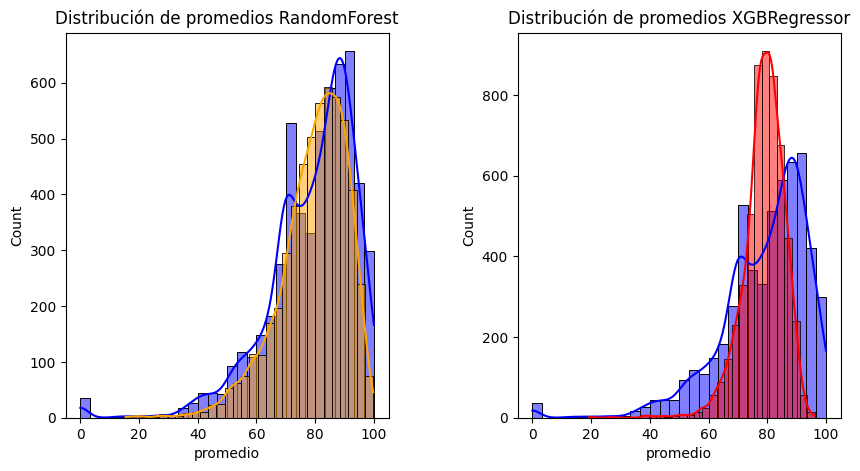

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.subplot(1, 2, 1)
sns.histplot(dataperiodos['promedio'], kde=True, color='blue', bins=30,label='Real')
sns.histplot(dataperiodos['promedioxperiodo'], kde=True, color='orange', bins=30,label='Prediccion RandomForest')
plt.title('Distribución de promedios RandomForest')
plt.subplot(1, 2, 2)
sns.histplot(dataperiodos['promedio'], kde=True, color='b', bins=30,label='Real')
sns.histplot(dataperiodos['promedio_pred'], kde=True, color='r', bins=30,label='Prediccion XGBoost')
plt.title('Distribución de promedios XGBRegressor')
plt.show()

### Evaluación del Modelo de Machine Learning con Validación Cruzada para Comparar con RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

caracteristicas = ['clave_alumno','prepa','sexo','clave_carrera','colonia','periodo_act']
X_1 = dataperiodos[caracteristicas]
y_1 = dataperiodos['promedio']

#se define el preprocesamiento de los datos
#most_frequent se refiere a que se reemplazan los valores faltantes por la moda
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#se define el preprocesamiento de los datos
#se aplica el preprocesamiento a las columnas numericas y categoricas
preprocessor = ColumnTransformer(
    transformers=[ # No numerical features in this case
        ('cat', categorical_transformer, caracteristicas)
    ])
# Define the model
#model = RandomForestRegressor(n_estimators=50, random_state=0)
# Create and evaluate the pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
my_pipeline2 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', mymodel)
                             ])
scores = -1 * cross_val_score(my_pipeline, X_1, y_1,
                              cv=5,
                              scoring='neg_mean_absolute_error')
scores2 = -1 * cross_val_score(my_pipeline2, X_1, y_1,
                                cv=5,
                                scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores, scores2)


MAE scores:
 [13.61817544 10.14017307 11.63655626 13.2790436  12.873796  ] [12.68890165 11.9729284  11.66697157 12.67494129 13.18924169]


### mostramos una grafica de barra de los scores obtenidos por el modelo de validacion cruzada y vemos que el modelo de machine learning de random forest no estan bueno debido a que tarda y 

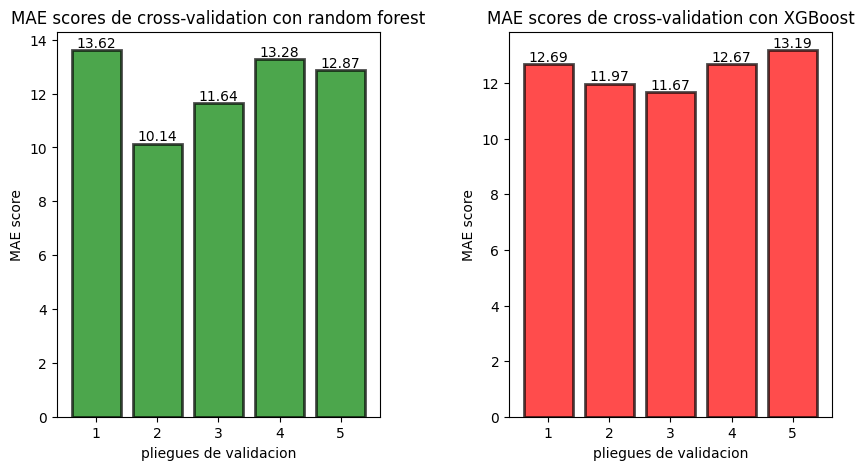

In [ ]:
#pon una grafica de barras con los scores 
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(10, 5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)
plt.subplot(1, 2, 1)
plt.bar(range(1, 6), scores, color='g', alpha=0.7, edgecolor='black', linewidth=2)
for i in range(1, 6):
    plt.text(i, scores[i-1], str(round(scores[i-1], 2)), ha = 'center', va = 'bottom')
plt.xlabel('pliegues de validacion')
plt.ylabel('MAE score')
plt.title('MAE scores de cross-validation con random forest')
plt.subplot(1, 2, 2)
plt.bar(range(1, 6), scores2, color='r', alpha=0.7, edgecolor='black', linewidth=2)
for i in range(1, 6):
    plt.text(i, scores2[i-1], str(round(scores2[i-1], 2)), ha = 'center', va = 'bottom')
plt.xlabel('pliegues de validacion')
plt.ylabel('MAE score')
plt.title('MAE scores de cross-validation con XGBoost')
plt.show()

### Agregamos una nueva columna para identificar a los alumnos que estan en riesgo de tener bajo rendimiento academico en cierto periodo y eliminamos la columna del modelo que no decidimos quedarnos con su prediccion

In [ ]:
dataperiodos
umbral = 70
dataperiodos['alumnoEnRiesgoBajoRendimiento'] = dataperiodos['promedioxperiodo'].apply(lambda x: "En riesgo" if x < umbral else "Sin riesgo")

# mostrar el ultimo periodo cursado de cada alumno
ultimo_periodo = dataperiodos.groupby('clave_alumno')['anio_ingreso_periodo'].max().reset_index()

# ordenar por clave_alumno y anio_ingreso_periodo
dataperiodos = dataperiodos.sort_values(['clave_alumno','anio_ingreso_periodo'])

dataperiodos.to_csv('dataperiodosSomitir.csv',index=False)


### Dejar en el dataset de dataperiodos solo 1 campo por periodo_act (sin repeticiones)

In [ ]:
# Dejar en el dataset de dataperiodos solo 1 campo por periodo_act con unique
dataperiodos = dataperiodos.drop_duplicates(subset=['clave_alumno','periodo_act'])
#eliminar la columna promedio_pred
dataperiodos
dataperiodos.to_csv('dataperiodosnuevo.csv',index=False)
dataperiodos

,clave_alumno,clave_carrera,sexo,prepa,colonia,municipio,ciudad,causa_salida,periodo_act,anio_ingreso_periodo,promedio,promedioxperiodo,alumnoEnRiesgoBajoRendimiento
8829,1149,5,1,56,VILLA DEL REAL,25006.0,Culiacan,1,ago-dic,2001,57.500000,48.394133,En riesgo
8836,1149,5,1,56,VILLA DEL REAL,25006.0,Culiacan,1,ene-jun,2002,79.600000,57.987003,En riesgo
8843,1149,5,1,56,VILLA DEL REAL,25006.0,Culiacan,1,verano,2005,70.000000,75.050000,Sin riesgo
6348,3156,2,1,112,LAS GRANJAS,25006.0,Culiacan,1,ago-dic,2004,77.166667,48.414240,En riesgo
6353,3156,2,1,112,LAS GRANJAS,25006.0,Culiacan,1,ene-jun,2006,18.750000,50.201993,En riesgo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6347,11843,1,2,635,SAN RAFAEL,25014.0,Rosario,1,ago-dic,2010,70.833333,77.313000,Sin riesgo
5595,11844,0,2,107,NUEVO CULIACAN,25006.0,Culiacan,1,ago-dic,2010,65.000000,75.342780,Sin riesgo
12784,11845,7,1,117,LOS ANGELES,25006.0,Culiacan,1,ago-dic,2010,84.666667,86.093500,Sin riesgo
5596,11850,0,1,156,EL POBLADO,25018.0,Navolato,1,ago-dic,2010,52.333333,67.464517,En riesgo


## Share - Compartir los datos

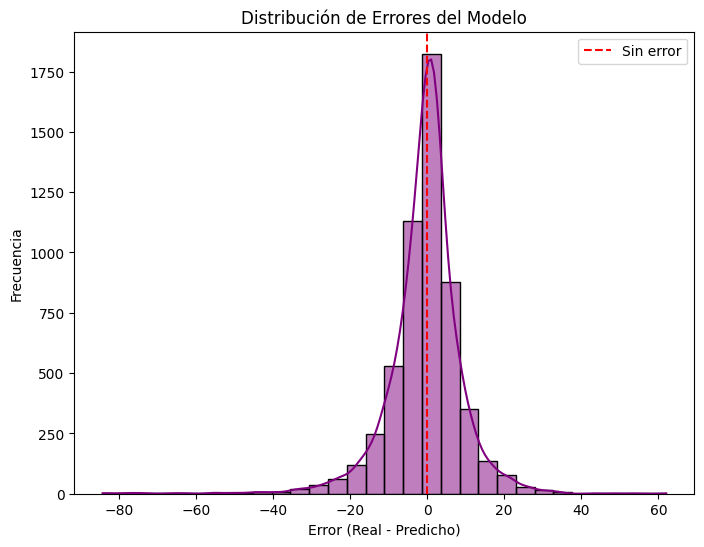

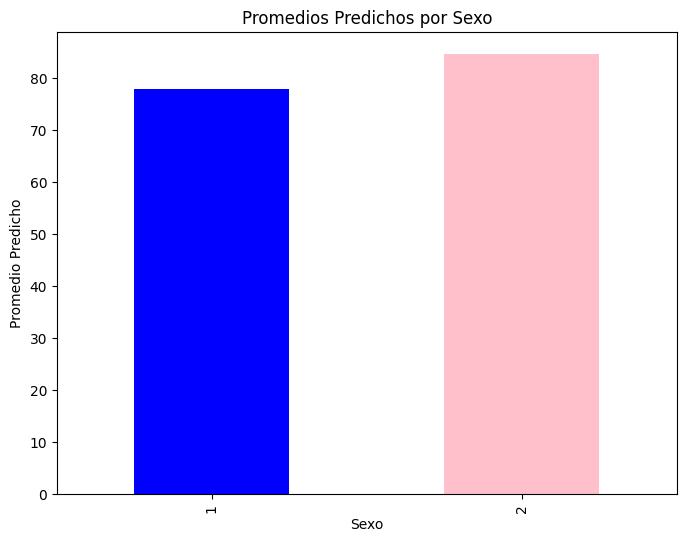

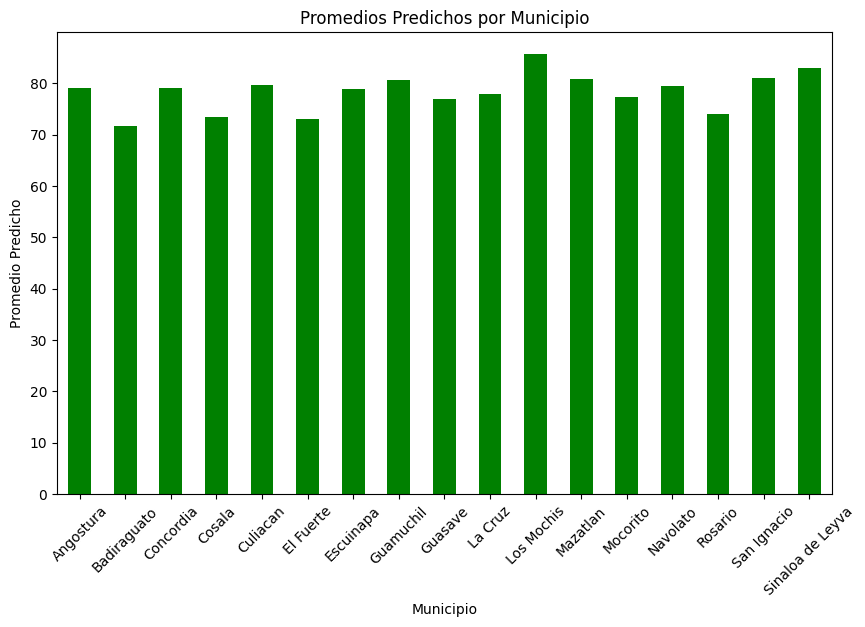

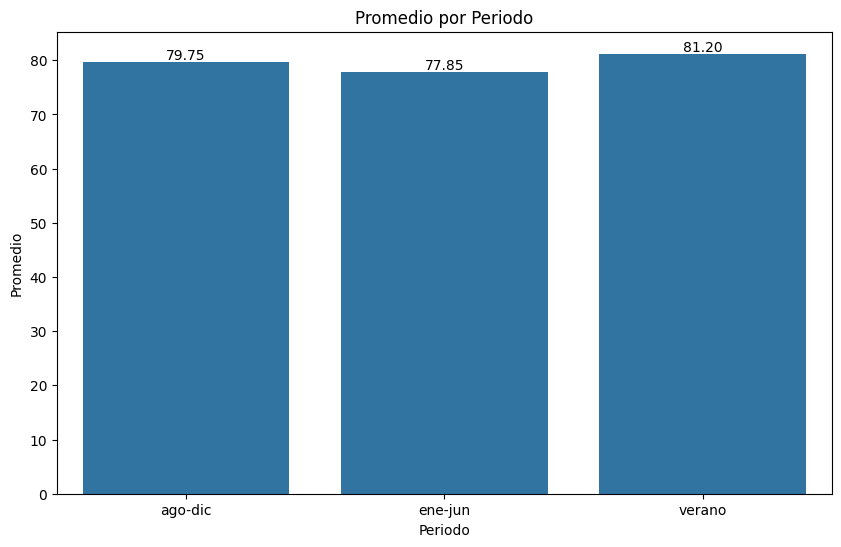

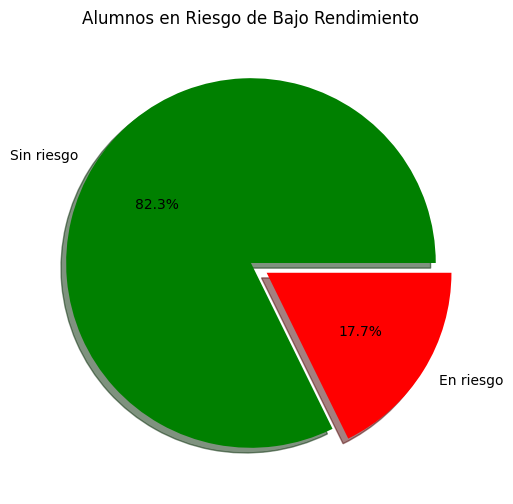

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
y_real = dataperiodos['promedio']
y_pred = dataperiodos['promedioxperiodo']
# Grafico de distribución
# Calcular errores
errores = y_real - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(errores, kde=True, color='purple', bins=30)
plt.axvline(x=0, color='red', linestyle='--', label='Sin error')
plt.xlabel('Error (Real - Predicho)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores del Modelo')
plt.legend()
plt.show()
#Grafico de barras
# Promedio por sexo
promedio_por_sexo = dataperiodos.groupby('sexo')['promedioxperiodo'].mean()
# Promedio por municipio
promedio_por_municipio = dataperiodos.groupby('ciudad')['promedioxperiodo'].mean()
plt.figure(figsize=(8, 6))
promedio_por_sexo.plot(kind='bar', color=['blue', 'pink'])
plt.xlabel('Sexo')
plt.ylabel('Promedio Predicho')
plt.title('Promedios Predichos por Sexo')
plt.show()
#Grafico de barras de promedio por municipio
plt.figure(figsize=(10, 6))
promedio_por_municipio.plot(kind='bar', color='green')
plt.xlabel('Municipio')
plt.ylabel('Promedio Predicho')
plt.title('Promedios Predichos por Municipio')
plt.xticks(rotation=45)
plt.show()
#Grafico de barras de promedio por periodo
promedio_periodos = dataperiodos.groupby('periodo_act')['promedioxperiodo'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(
    x='periodo_act', 
    y='promedioxperiodo', 
    data=promedio_periodos, 
)
# Agregar los valores encima de las barras
for index, row in promedio_periodos.iterrows():
    plt.text(
        x=index, 
        y=row['promedioxperiodo'] + 0.5,  # Ajustar la posición vertical
        s=f"{row['promedioxperiodo']:.2f}",  # Mostrar con 2 decimales
        ha='center', 
        fontsize=10, 
        color='black'
    )
plt.xlabel('Periodo')
plt.ylabel('Promedio')
plt.title('Promedio por Periodo')
plt.xticks(rotation=0)
plt.show()
#Grafica de pastel de alumnos en riesgo
alumnos_riesgo = dataperiodos['alumnoEnRiesgoBajoRendimiento'].value_counts()
plt.figure(figsize=(8, 6))
alumnos_riesgo.plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red'], explode=(0, 0.1), shadow=True)
plt.title('Alumnos en Riesgo de Bajo Rendimiento')
plt.ylabel('')
plt.show()

